# Challenge Description 

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to
perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you
have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:
* For each user, determine her country based on the numeric IP address.
* Build a model to predict whether an activity is fraudulent or not. Explain how different
assumptions about the cost of false positives vs false negatives would impact the model.
* Your boss is a bit worried about using a model she doesn't understand for something as
important as fraud detection. How would you explain her how the model is making the
predictions? Not from a mathematical perspective (she couldn't care less about that), but
from a user perspective. What kinds of users are more likely to be classified as at risk?
* What are their characteristics?
* Let's say you now have this model which can be used live to predict in real time if an
activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

# Data

There are 2 data files that you will need to load (in the problem2 folder in the data folder): 

### Fraud_Data.csv
**Columns:**
* **user_id** : Id of the user. Unique by user
* **signup_time** : the time when the user created her account (GMT time)
* **purchase_time** : the time when the user bought the item (GMT time)
* **purchase_value** : the cost of the item purchased (USD)
* **device_id** : the device id. You can assume that it is unique by device. I.e., transactions
with the same device ID means that the same physical device was used to buy.
* **source** : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing
the site address on the browser).
* **browser** : the browser used by the user.
* **sex** : user sex: Male/Female
* **age** : user age
* **ip_address** : user numeric ip address
* **class** : this is what we are trying to predict: whether the activity was fraudulent (1) or not
(0).

### IpAddress_to_Country.csv
**Columns:**
* **lower_bound_ip_address** : the lower bound of the numeric ip address for that country
* **upper_bound_ip_address** : the upper bound of the numeric ip address for that country
* **country** : the corresponding country. If a user has an ip address whose value is within
the upper and lower bound, then she is based in this country.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
## below is the code used to merge the ip address to the country 
## this takes a few minutes to run, so it's commented out here and
## a convenience data set is provided instead

# fraud = pd.read_csv('./data/problem2/Fraud_Data.csv')
# ip = pd.read_csv('./data/problem2/IpAddress_to_Country.csv')

# fraud['country'] = np.nan

# for i, row in fraud.iterrows():
#     mask = ((row.ip_address >= ip.lower_bound_ip_address) & 
#             (row.ip_address <= ip.upper_bound_ip_address))
#     country = ip.loc[mask, 'country'].tolist()
#     if any(country):
#         fraud.loc[i, 'country'] = country[0]

In [3]:
# instead we'll just use the convenience data set

fraud = pd.read_csv('./data/problem2/fraud_with_countries.csv')
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [4]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           129146 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [5]:
fraud['signup_time'] = pd.to_datetime(fraud.signup_time)
fraud['purchase_time'] = pd.to_datetime(fraud.purchase_time)

In [6]:
fraud['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

In [7]:
# check if there are any duplicate user_ids
print(fraud.user_id.duplicated().sum())

0


In [8]:
# check if more than one user using same device
fraud.device_id.duplicated().sum()

13156

In [9]:
fraud.groupby('device_id').user_id.count().sort_values(ascending=False).head()

device_id
KIPFSCNUGOLDP    20
ITUMJCKWEYNDD    20
CQTUVBYIWWWBC    20
NGQCKIADMZORL    20
EQYVNEGOFLAWK    20
Name: user_id, dtype: int64

In [10]:
# check if more than one user using same ip
fraud.ip_address.duplicated().sum()

7600

In [11]:
fraud.groupby('ip_address').user_id.count().sort_values(ascending=False).head()

ip_address
1.502818e+09    20
5.760609e+08    20
3.874758e+09    20
2.050964e+09    20
3.484934e+08    19
Name: user_id, dtype: int64

In [12]:
# add two features for the number of times a particular device and ip address are used
fraud['device_count'] = fraud.groupby('device_id').device_id.transform('count')
fraud['ip_count'] = fraud.groupby('ip_address').ip_address.transform('count')

In [13]:
# add feature for time between signup and purchase
# convert to seconds
fraud['time_diff'] = fraud.purchase_time - fraud.signup_time
fraud['time_diff'] = fraud.time_diff.dt.seconds

#replace Nans and give codes to countries
fraud.country.fillna('Unknown', inplace=True)

In [14]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 15 columns):
user_id           151112 non-null int64
signup_time       151112 non-null datetime64[ns]
purchase_time     151112 non-null datetime64[ns]
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
device_count      151112 non-null int64
ip_count          151112 non-null float64
time_diff         151112 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(6), object(5)
memory usage: 17.3+ MB


In [15]:
ignore = ['class', 'user_id', 'signup_time', 'purchase_time', 'device_id', 'ip_address']
cat_cols = []
for col in fraud.columns: 
    if fraud[col].dtype == 'object' and col not in ignore:
        fraud[col+'_codes'] = pd.Categorical(fraud[col]).codes
        cat_cols.append(col)

for col in ['purchase_value', 'age', 'device_count', 'ip_count', 'time_diff']:
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(fraud[col].values.reshape(-1,1))
    fraud[col] = scaler.fit_transform(fraud[col].values.reshape(-1,1))

/usr/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [16]:
# start with just a simple logistic regression
model = LogisticRegression()
train, test = sklearn.model_selection.train_test_split(fraud, test_size=0.3, stratify=fraud['class'])

to_drop = ignore + cat_cols
train_X = train.drop(to_drop, axis=1)
train_y = train['class']

fit = model.fit(train_X, train_y)

test_X = test.drop(to_drop, axis=1)
test_y = test['class']

preds = fit.predict(test_X)

In [17]:
pd.DataFrame(sklearn.metrics.confusion_matrix(test_y, preds), 
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

,Pred -,Pred +
Actual -,40856,233
Actual +,2053,2192


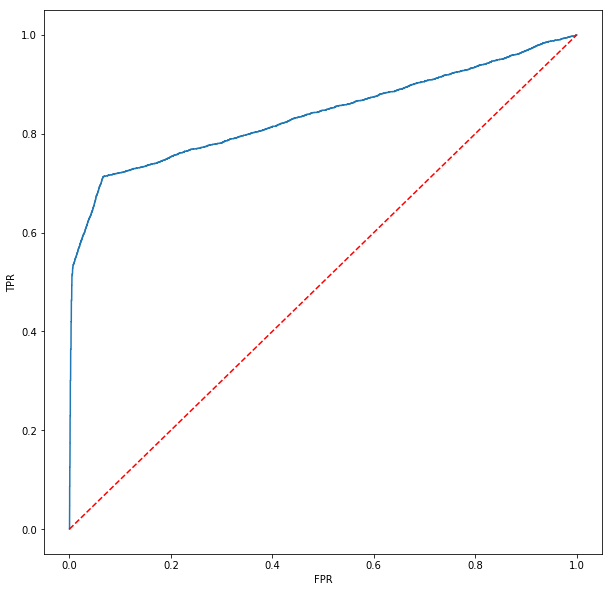

In [18]:
# question asks about true positive vs. false positive rates
# so let's take a look at the the ROC curve

preds = fit.predict_proba(test_X)[:,1]
fpr, tpr, thresh = sklearn.metrics.roc_curve(test_y, preds)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

In [19]:
# and we should also look at what the weights for the different features are
pd.DataFrame([[feat, coef] for feat, coef 
              in zip(test_X.columns, fit.coef_[0])], 
             columns = ['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False)

,Feature,Coefficient
2,device_count,4.186102
7,sex_codes,0.022955
8,country_codes,-0.000005
0,purchase_value,-0.000833
6,browser_codes,-0.002639
1,age,-0.016715
5,source_codes,-0.019631
4,time_diff,-0.254443
3,ip_count,-2.776128


In [20]:
# see how a RF does in comparison
model = RandomForestClassifier(150, oob_score=True, verbose=True, n_jobs=-1)

train, test = sklearn.model_selection.train_test_split(fraud, test_size=0.3, stratify=fraud['class'])

to_drop = ignore + cat_cols
train_X = train.drop(to_drop, axis=1)
train_y = train['class']

fit = model.fit(train_X, train_y)

test_X = test.drop(to_drop, axis=1)
test_y = test['class']

preds = fit.predict(test_X)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    9.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.6s finished


In [21]:
pd.DataFrame(sklearn.metrics.confusion_matrix(test_y, preds), 
             columns=['Pred -', 'Pred +'], index=['Actual -', 'Actual +'])

,Pred -,Pred +
Actual -,41025,64
Actual +,1927,2318


In [22]:
fit.oob_score_

0.95551059766681168

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    1.5s finished


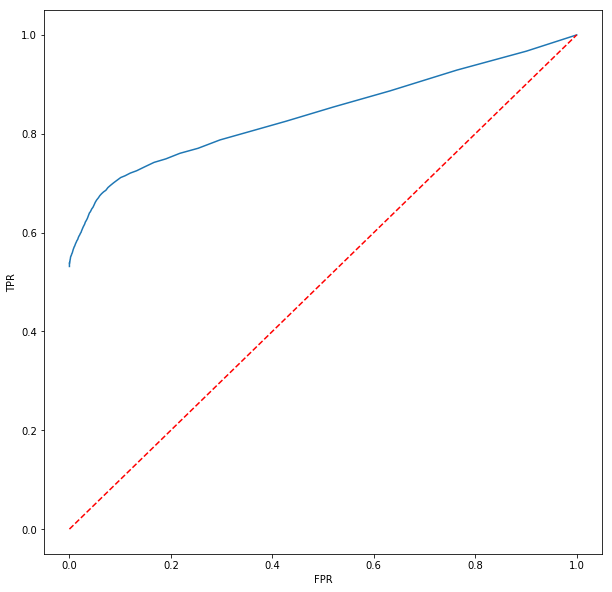

In [23]:
preds = fit.predict_proba(test_X)[:,1]
fpr, tpr, thresh = sklearn.metrics.roc_curve(test_y, preds)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')

In [24]:
pd.DataFrame([[feat, feat_imp] for feat, feat_imp 
              in zip(test_X.columns, fit.feature_importances_)], 
             columns = ['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

,Feature,Importance
4,time_diff,0.449482
3,ip_count,0.162328
2,device_count,0.107909
0,purchase_value,0.097422
1,age,0.079174
8,country_codes,0.057189
6,browser_codes,0.023097
5,source_codes,0.012834
7,sex_codes,0.010565


### Some general conclusions

* We can achieve a FPR rate of essentially zero while achieving a TPR of ~0.5. Depending on how the cost/value of a False Negative (particularly in relation to False positives), we can achieve a higher TPR at the cost of more False Positives. 

* time_diff, ip_count, and device_count had the greatest importance in both models. These are likely indicators of fraud. E.g. multiple users at a single ip address 